In [1]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [10]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
    RioCallback,
    recursive_scan,
    Para_init,
    write_excel_xlsx,
    Run_P3_model,
    Plot_Last_Single_Step,
    GetSol_dict,
    Plot_Loc_Var_2,
    Plot_Fig_1,
    Plot_Loc_Var_sol_6,
)

In [3]:
def electrolyte_conductivity_Valoen2005Constant_wEC_Haya(c_e,c_EC, T):# Mark Ruihe change
    # mol/m3 to molar
    c_e = c_e / 1000
    sigma = (c_e <= 4.5) * (
        (1e-3 / 1e-2) * (
        c_e
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + c_e * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + c_e ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    )) + (c_e > 4.5) *  (
        (1e-3 / 1e-2) * (
        4.5
        * (
            (-10.5 + 0.0740 * T - 6.96e-5 * T ** 2)
            + 4.5 * (0.668 - 0.0178 * T + 2.80e-5 * T ** 2)
            + 4.5 ** 2 * (0.494 - 8.86e-4 * T)
        )
        ** 2
    ))
    a=1.092; b=-6.497e-6; c=-0.7877; d=-0.0004808
    ratio= (
        a*exp(b*c_EC)+c*exp(d*c_EC) )
    return sigma*ratio

In [4]:
########################  Input  ########################
# all values here must be a list, even it is a single object
Para_dict_All = {
   "Total ageing cycles":[300,],
   "SaveAsList":[  [100,10,1,1,1,1],  ],
   "Ageing temperature":[25,],
   #"Particle mesh points":[120,],
   #"Exponential mesh stretch":[2.3,],
   "Para_Set":[ "Chen2020",],
   "electrolyte":["lipf6_Valoen2005Constant",],
    
    "Model option":[
        {
            "calculate discharge energy":"true",
            "SEI":"solvent-diffusion limited",          
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",     
            "solvent diffusion": "none"     },
        {
            "calculate discharge energy":"true",
            "SEI":"solvent-diffusion limited",          
            "SEI film resistance":"distributed",          
            "SEI porosity change":"true",     
            "solvent diffusion": "EC wo refill"   },
    ],
   # solvent diffusion parameters:
   "EC transference number":[-1.4,],
   "Cation transference number":[0.28,],
   "EC Lithium ion cross diffusivity [m2.s-1]":[3e-11,],
   "EC diffusivity in electrolyte [m2.s-1]":[3.2e-10,],

   # DFN parameter
   "Upper voltage cut-off [V]":[4.21,],
   "Lower voltage cut-off [V]":[2.49,],
   #"Negative electrode diffusivity [m2.s-1]":[2e-13,],
   #"Positive electrode diffusivity [m2.s-1]":[1e-13,],
   # if want a function, add 'Func', 
   #    if want a constant, delete Func
   # NOTE: Constant will overwrite Func
   "Func Electrolyte conductivity [S.m-1]":[
        "electrolyte_conductivity_Valoen2005Constant_wEC_Haya",],
   # general SEI
   'SEI resistivity [Ohm.m]':[2E5,],
   "Ratio of lithium moles to SEI moles":[1,],
   # solvent-diffusion limited
   'Outer SEI solvent diffusivity [m2.s-1]':[1.7e-22,],
   'Bulk solvent concentration [mol.m-3]':[4541.0,],
   # interstitial-diffusion limited
   'Inner SEI lithium interstitial diffusivity [m2.s-1]':[1e-12,],    
   'Lithium interstitial reference concentration [mol.m-3]':[15,],
   # ec-reaction limited
   'EC diffusivity  in SEI [m2.s-1]':[2e-20,],
   'SEI kinetic rate constant [m.s-1]':[1e-19,],
   'EC initial concentration in electrolyte [mol.m-3]':[4541.0,],
}
Para_dict_list = []
recursive_scan(Para_dict_list,Para_dict_All, list(Para_dict_All.keys()), {})

In [5]:
keys_loc_AGE = [ # MAY WANT TO SELECT AGEING CYCLE later
    # Default output:
    "x [m]",
    "x_n [m]",
    "x_s [m]",
    "x_p [m]",
    # default: end; 
    "CCend Negative electrode porosity",
    "CCend Positive electrode potential [V]",
    "CCend Negative electrode interfacial current density [A.m-2]",
    "CCend Electrolyte potential [V]",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend EC concentration [mol.m-3]",
    "CCend c(EC) over c(Li+)",
    "CCend Electrolyte current density [A.m-2]",
    "CCend Electrolyte diffusivity [m2.s-1]",
    "CCend Electrolyte conductivity [S.m-1]",
    "CCend Negative electrode SEI interfacial current density [A.m-2]",

    "CDend Negative electrode porosity",
    "CDend Positive electrode potential [V]",
    "CDend Negative electrode interfacial current density [A.m-2]",
    "CDend Electrolyte potential [V]",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend EC concentration [mol.m-3]",
    "CDend c(EC) over c(Li+)",
    "CDend Electrolyte current density [A.m-2]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
    "CDend Negative electrode SEI interfacial current density [A.m-2]",

]
keys_tim_AGE = [
    # default: CD
    "CD Time [h]",
    "CC Time [h]",
    "CV Time [h]",
    "CD Terminal voltage [V]",
    "CC Terminal voltage [V]",
    "RE Terminal voltage [V]",
]
keys_cyc_AGE = [   # default: CDend
    "Discharge capacity [A.h]",
    "CDend Loss of capacity to SEI [A.h]",
    "CDend Local ECM resistance [Ohm]",
    "CDsta Negative electrode SOC", 
    "CDend Negative electrode SOC",
    "CDsta Positive electrode SOC", 
    "CDend Positive electrode SOC",
    "CDend Negative electrode capacity [A.h]",
    "CDend Positive electrode capacity [A.h]",
]
keys_all_AGE = [keys_loc_AGE,keys_tim_AGE,keys_cyc_AGE];

In [6]:
# define experiments and scan!
V_max = 4.2;        V_min = 2.5; 
exp_AGE = [
   (f"Discharge at 1 C until {V_min} V", 
   f"Charge at 1 C until {V_max} V",  # (5 minute period)
   f"Hold at {V_max} V until C/20"),  ]# (5 minute period)
exp_AGE_2 = [
   (f"Discharge at 1 C until {V_min} V (5 seconds period)", 
   f"Charge at 1 C until {V_max} V (5 seconds period)", 
   f"Hold at {V_max} V until C/20 (5 seconds period)"),]
# step index for ageing
exp_AGE_CD = [ (
   f"Discharge at 1 C until {V_min} V (1 seconds period)",   ) ]
exp_AGE_CC = [ (
   f"Charge at 1 C until {V_max} V (1 seconds period)" ) ]
exp_AGE_CV = [ (
   f"Hold at {V_max} V until C/20 (1 seconds period)" ) ]
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

Exp_AGE_List     = [
    exp_AGE,exp_AGE,exp_AGE_2,
    exp_AGE_CD,exp_AGE_CC,exp_AGE_CV];
cycle_no = -1; 
exp_index_pack = [
   cycle_no,step_AGE_CD,
   step_AGE_CC,step_AGE_CV,];
# Path and save to excel
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R8/'; 
Target  = 't2_test_funP3/'
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target);
book_name_xlsx = 'TEST_1.xlsx';sheet_name_xlsx = 'Results';
Path_pack = [BasicPath,Target,book_name_xlsx,sheet_name_xlsx,];
# Write the head for excel file:
head_list = list(Para_dict_list[0].keys())
head_list.insert(0,"Index");
head_list.extend([ "exp_AGE_text", 
   "Cap Loss","LLI to SEI",
   "LAM to Neg","LAM to Pos",
   "Error"])
write_excel_xlsx(
    BasicPath + Target+book_name_xlsx, 
    sheet_name_xlsx, [head_list])
# scan:
index_xlsx = 0; Sol_All_All = [];
Succ_Cyc_All = []; 
for Para_dict_i in Para_dict_list:
   index_xlsx += 1;
   Sol_All,Succ_Cyc = Run_P3_model(
      index_xlsx, Para_dict_i,   Path_pack , 
      keys_all_AGE,   Exp_AGE_List, exp_index_pack )
   Sol_All_All.append(Sol_All)
   Succ_Cyc_All.append(Succ_Cyc)


Successfully create a excel file
Confirm: using solvent-diffusion limited
try to run 100 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2022-11-01 01:42:11.430 - [ERROR] callbacks.on_experiment_error(226): Simulation error: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.


Failed and shorten cycles
try to run 10 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2022-11-01 01:42:40.448 - [ERROR] callbacks.on_experiment_error(226): Simulation error: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.


Failed and shorten cycles
try to run 1 cycles
Succeed! Now it is the 1th cycles
try to run 1 cycles
Succeed! Now it is the 2th cycles
try to run 1 cycles
Succeed! Now it is the 3th cycles
try to run 1 cycles
Succeed! Now it is the 4th cycles
try to run 1 cycles
Succeed! Now it is the 5th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 6th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 7th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 8th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 9th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2022-11-01 01:43:23.189 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Maximum voltage' was triggered during 'Charge at 1 C until 4.2 V (5 seconds period)'. The returned solution only contains up to step 2 of cycle 1. 


Failed and shorten cycles
try to run 1 cycles
Succeed! Now it is the 10th cycles
Succeed a single step and switch to next step normally
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2022-11-01 01:43:25.653 - [WARNING] callbacks.on_experiment_infeasible(233): 

	Experiment is infeasible: 'event: Maximum voltage' was triggered during 'Charge at 1 C until 4.2 V (1 seconds period)'. The returned solution only contains up to step 1 of cycle 1. 


Failed and shorten cycles
try to run 1 cycles
Failed and shorten cycles
Exit as no options left
Finally finish 10 cycles
Confirm: using solvent-diffusion limited
using EC wo refill for Li+
try to run 100 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2022-11-01 01:44:25.102 - [ERROR] callbacks.on_experiment_error(226): Simulation error: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.


Failed and shorten cycles
try to run 10 cycles
Succeed! Now it is the 10th cycles
try to run 10 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
2022-11-01 01:45:23.524 - [ERROR] callbacks.on_experiment_error(226): Simulation error: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDACalcIC returned "IDA_LINESEARCH_FAIL". Consult IDAS documentation.


Failed and shorten cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 11th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 12th cycles
try to run 1 cycles


At t = 0.00846658 and h = 1.77985e-014, the corrector convergence failed repeatedly or with |h| = hmin.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 13th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 14th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 15th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 16th cycles
try to run 1 cycles


The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.


Succeed! Now it is the 17th cycles
try to run 1 cycles


At t = 0.00548276 and h = 8.55123e-020, the corrector convergence failed repeatedly or with |h| = hmin.
The linesearch algorithm failed with too small a step.
The linesearch algorithm failed with too small a step.
At t = 0.00103898, , mxstep steps taken before reaching tout.
At t = 0.00015766, , mxstep steps taken before reaching tout.
At t = 0.00015766, , mxstep steps taken before reaching tout.
At t = 0.00015766, , mxstep steps taken before reaching tout.
At t = 1.41025e-006, , mxstep steps taken before reaching tout.
At t = 1.40981e-006, , mxstep steps taken before reaching tout.
At t = 1.4101e-006, , mxstep steps taken before reaching tout.
At t = 1.40984e-006, , mxstep steps taken before reaching tout.
At t = 1.41015e-006, , mxstep steps taken before reaching tout.
2022-11-01 01:46:17.420 - [ERROR] callbacks.on_experiment_error(226): Simulation error: Maximum number of decreased steps occurred at t=1582.0996791887687. Try solving the model up to this time only or reducing dt_max (

Failed and shorten cycles
try to run 1 cycles
Succeed! Now it is the 18th cycles
Succeed a single step and switch to next step normally
try to run 1 cycles
Failed and shorten cycles
try to run 1 cycles
Failed and shorten cycles
Exit as no options left
Finally finish 18 cycles


In [7]:
# find single step
Index_single_step = [];
for i in range(0,len(Sol_All_All)):
    j=0;
    while j <len(Sol_All_All[i]):
        #print(len(Sol_All_All[i][j].cycles[-1].steps))
        if len(Sol_All_All[i][j].cycles[-1].steps)==1:
            break
        j += 1
    if j < len(Sol_All_All[i]):
        Index_single_step.append(j)
        print("Single step starts from %d" %j)
    elif j==len(Sol_All_All[i]):
        Index_single_step.append(j)
        print("No single step")
    else:
        pass
for i in range(0,len(Sol_All_All)):
    for j in range(Index_single_step[i],len(Sol_All_All[i])):
        print(f"Num {j} has {len(Sol_All_All[i][j].cycles[-1].steps)} step")
 

Single step starts from 9
Single step starts from 8
Num 9 has 1 step
Num 8 has 1 step


Not all solution has full cycles
Not all solution has full cycles


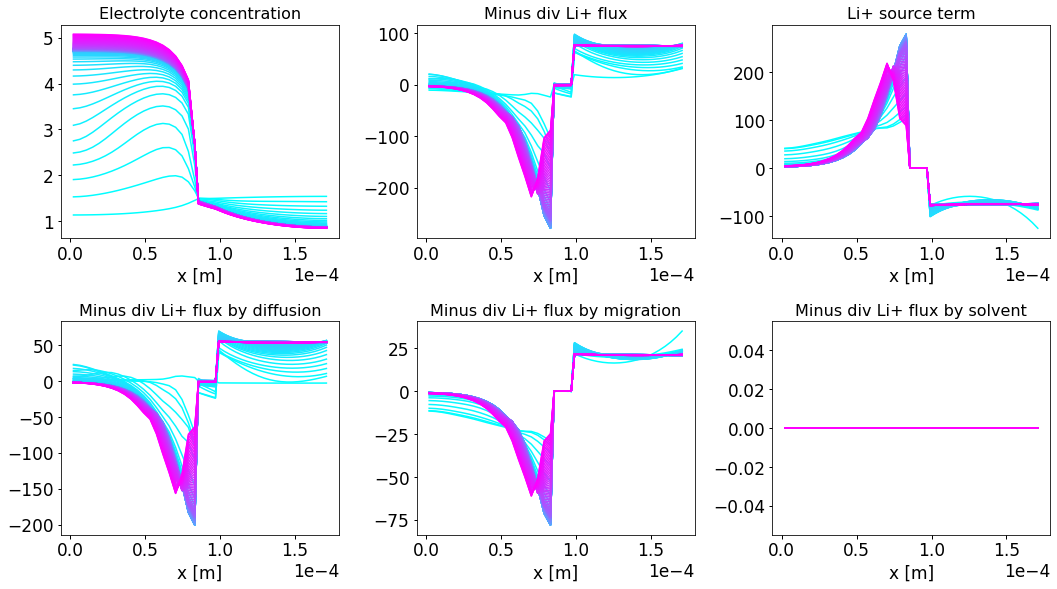

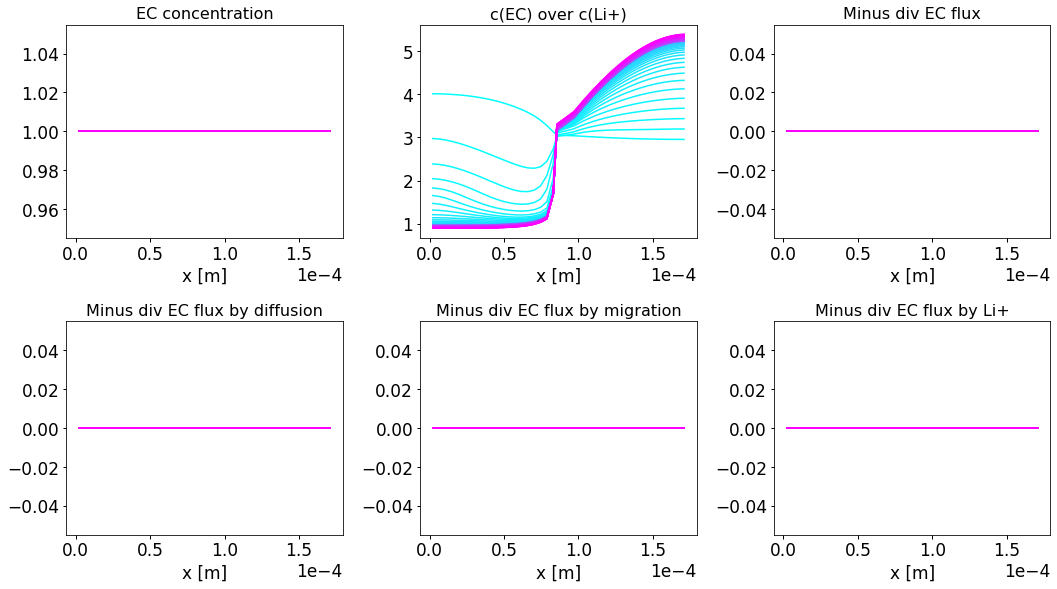

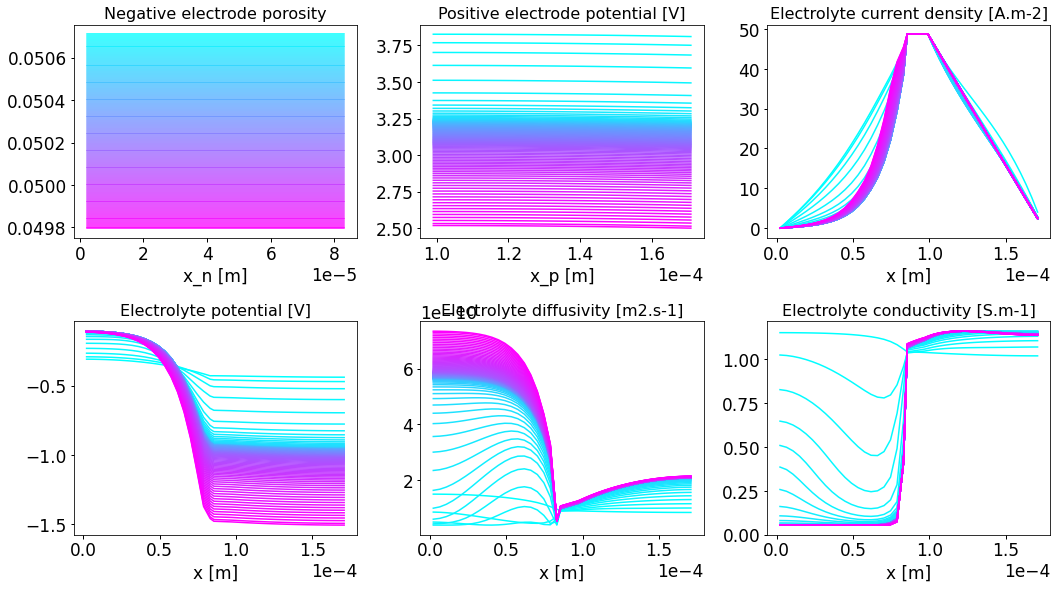

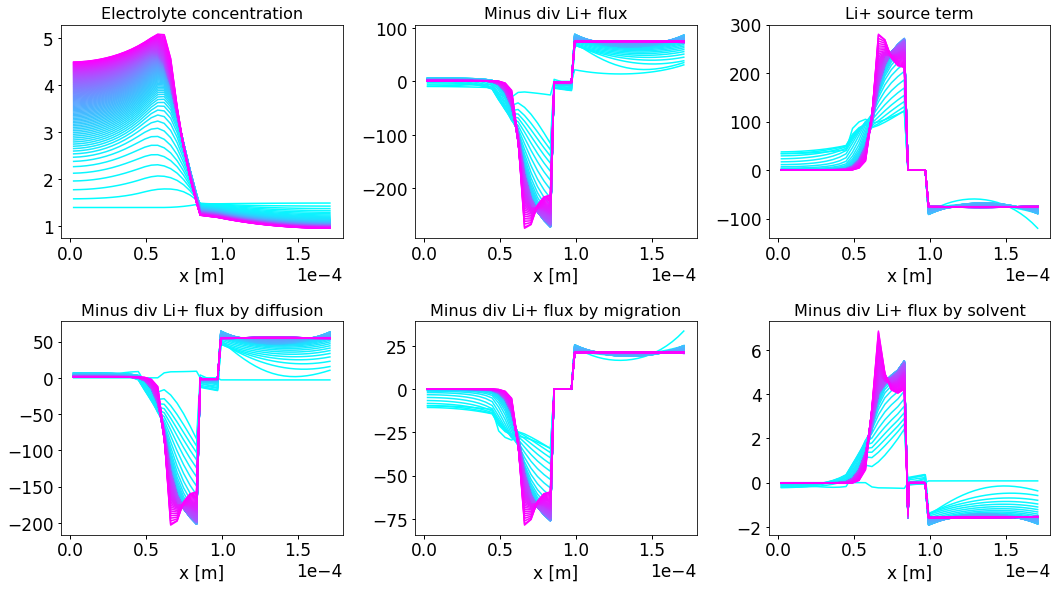

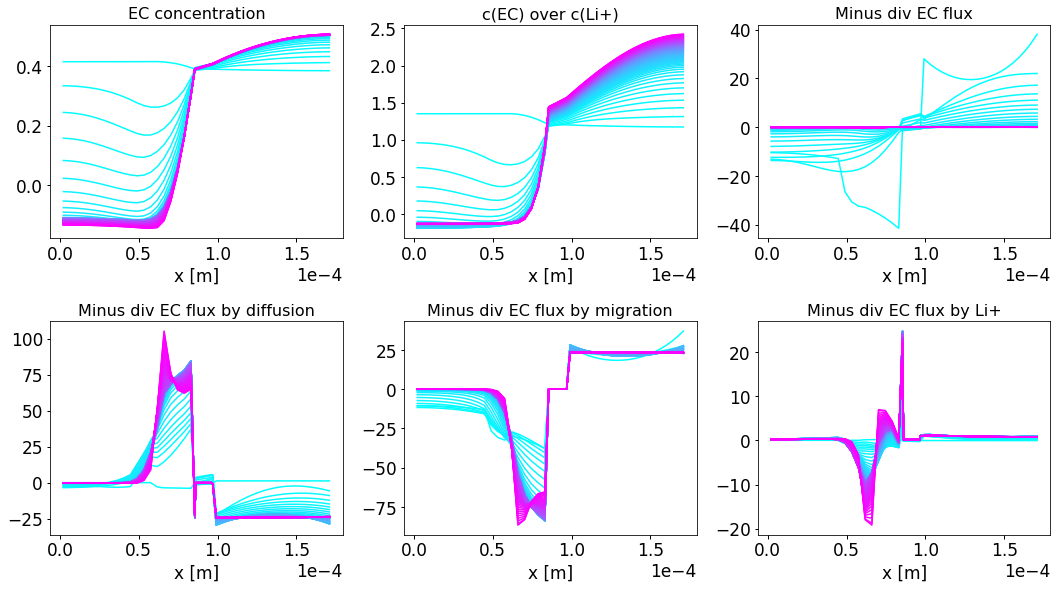

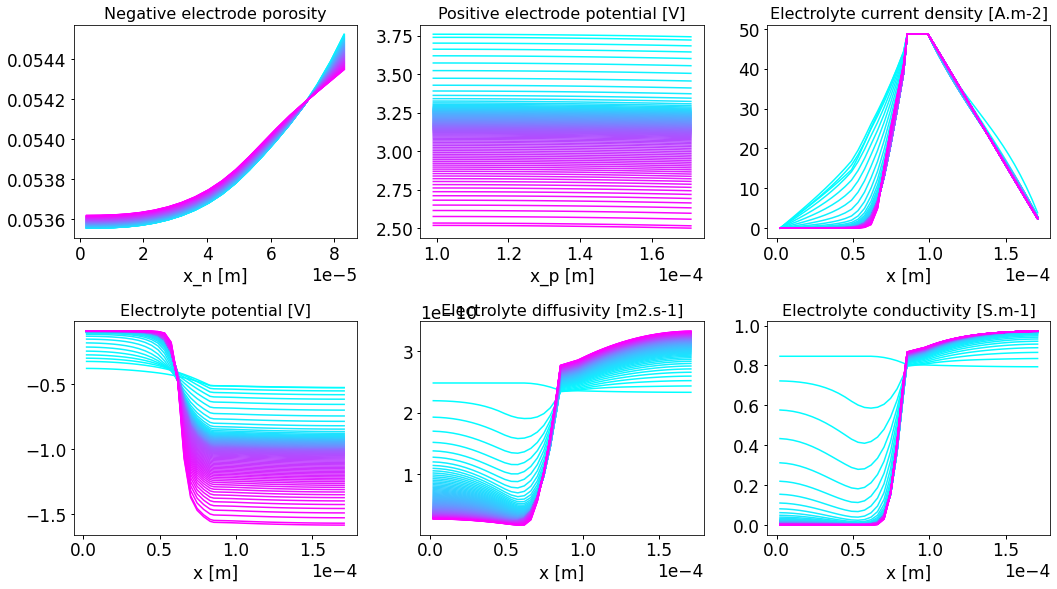

In [16]:
# Get dict and plot final single steps
index_cyc_All = []; # for each scan!
step_RPT_RE = -1
my_dict_AGE_all = [];Full_cycle_all = []
for i in range(0,len(Sol_All_All)):
    my_dict_AGE = {}; 
    for keys in keys_all_AGE:
        for key in keys:
            my_dict_AGE[key]=[];	
    if not os.path.exists(BasicPath + Target + f"{i}th Scan/"):
        os.mkdir(BasicPath + Target+  f"{i}th Scan/")
    Sol_all_i = Sol_All_All[i]
    Succ_Cyc_i = Succ_Cyc_All[i]
    Succ_Cyc_acc_i = np.cumsum(Succ_Cyc_i).tolist()
    Full_cycle = []
    # post-prosessing for full cycle range
    # prosess for the 1st solution: how many cycles do you have?
    if Index_single_step[i]<len(Sol_all_i):
        print("Not all solution has full cycles")
        for j in range(Index_single_step[i],len(Sol_all_i)):
            index_cyc = Succ_Cyc_acc_i[j];
            Plot_Last_Single_Step(
                Sol_all_i[j],0,0,BasicPath, 
                Target,i,index_cyc,"True","cool",17,200)

    for j in range(0,Index_single_step[i]):# post-prosess for normal full cycles
        if j == 0 and Succ_Cyc_acc_i[j]>1: # first solution:
            # get two solution
            cycle_no=0
            Full_cycle.append(0)
            my_dict_AGE_old = my_dict_AGE; del my_dict_AGE
            my_dict_AGE = GetSol_dict (
                my_dict_AGE_old,keys_all_AGE, Sol_all_i[j], 
                cycle_no, step_AGE_CD , step_AGE_CC , 
                step_RPT_RE, step_AGE_CV   ) 
                
            cycle_no=Succ_Cyc_i[j]-1
            Full_cycle.append(Succ_Cyc_acc_i[j])
            my_dict_AGE_old = my_dict_AGE; del my_dict_AGE
            my_dict_AGE = GetSol_dict (
                my_dict_AGE_old,keys_all_AGE, Sol_all_i[j], 
                cycle_no, step_AGE_CD , step_AGE_CC , 
                step_RPT_RE, step_AGE_CV   ) 
        else:
            # get only one solution
            cycle_no=Succ_Cyc_i[j]-1
            Full_cycle.append(Succ_Cyc_acc_i[j])
            my_dict_AGE_old = my_dict_AGE; del my_dict_AGE
            my_dict_AGE = GetSol_dict (
                my_dict_AGE_old,keys_all_AGE, Sol_all_i[j], 
                cycle_no, step_AGE_CD , step_AGE_CC , 
                step_RPT_RE, step_AGE_CV   ) 
    my_dict_AGE_all.append(my_dict_AGE)
    Full_cycle_all.append(Full_cycle)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


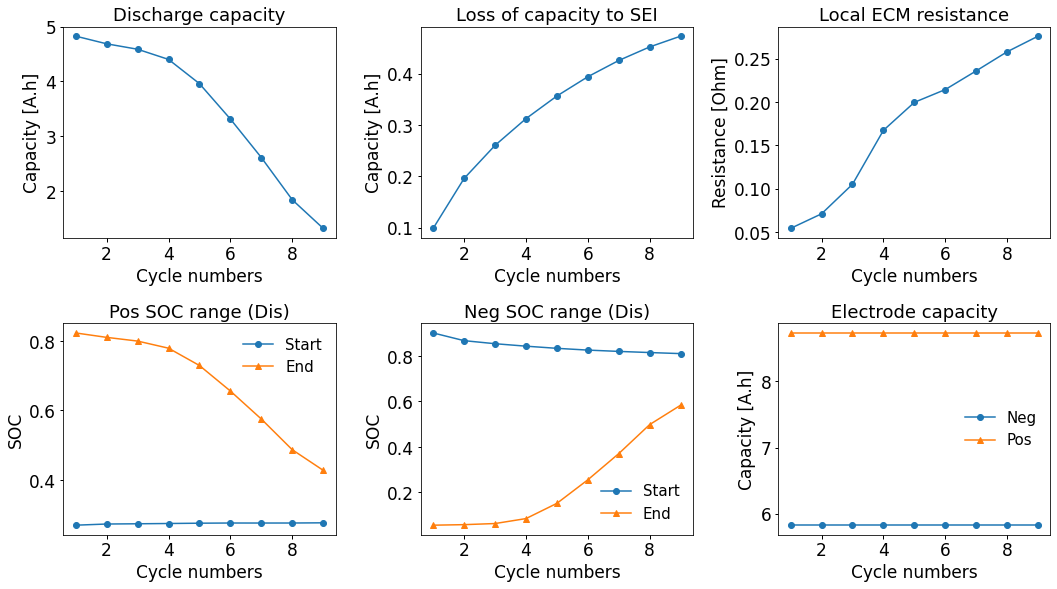

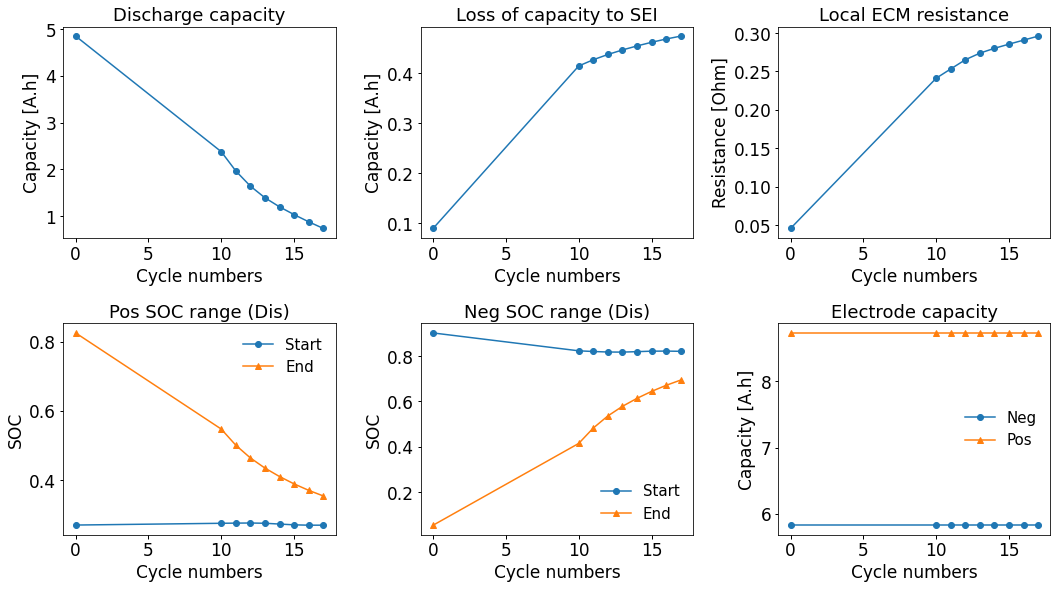

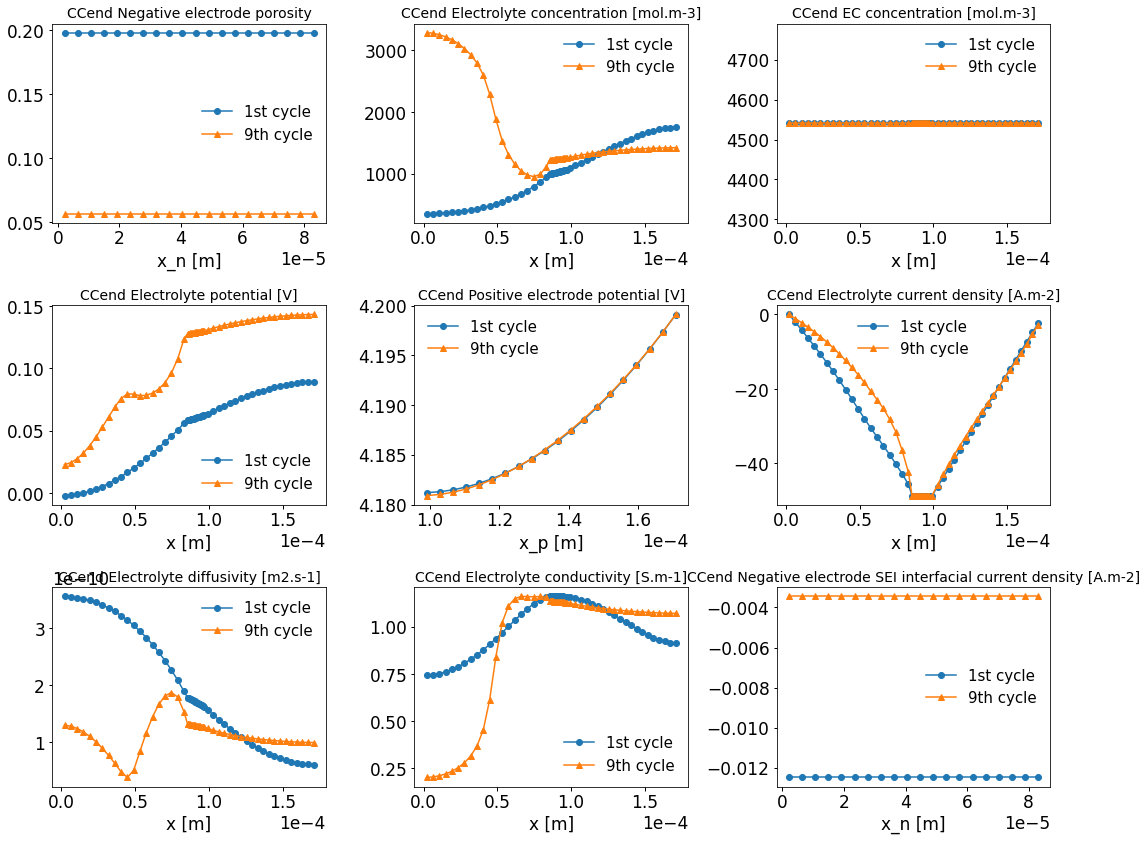

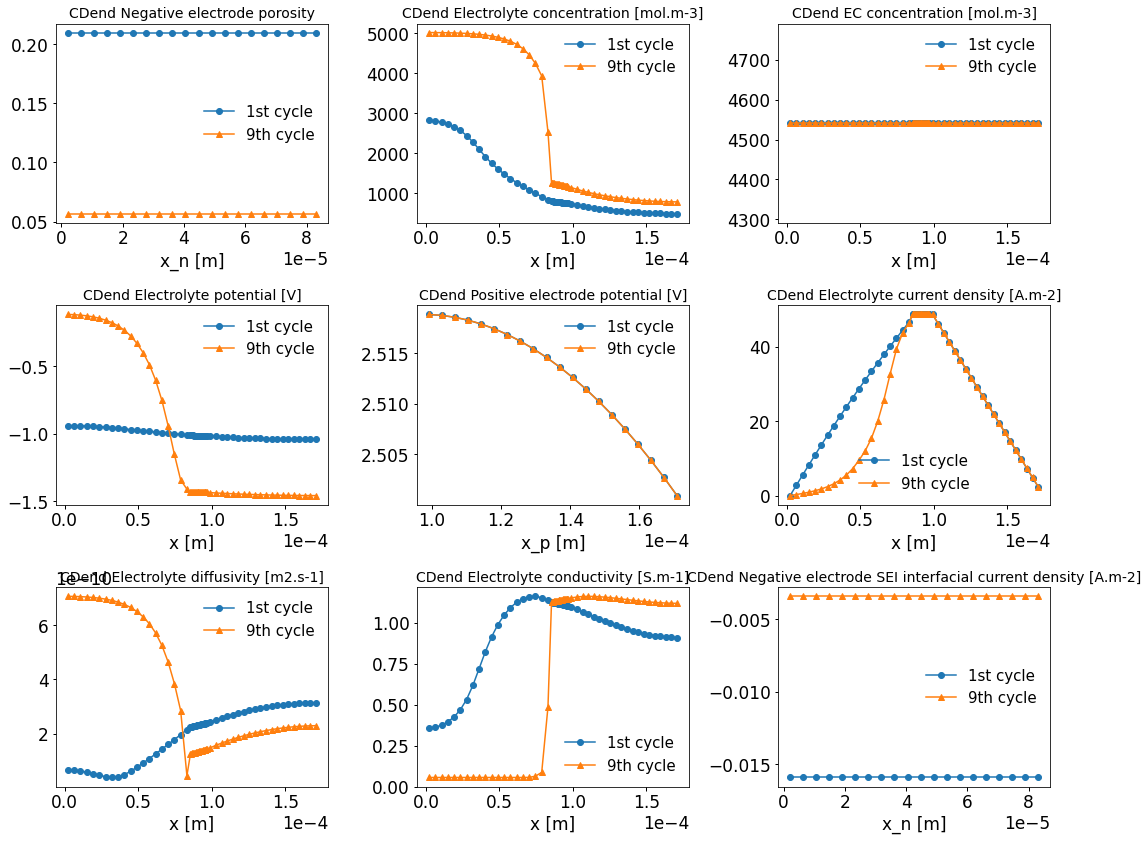

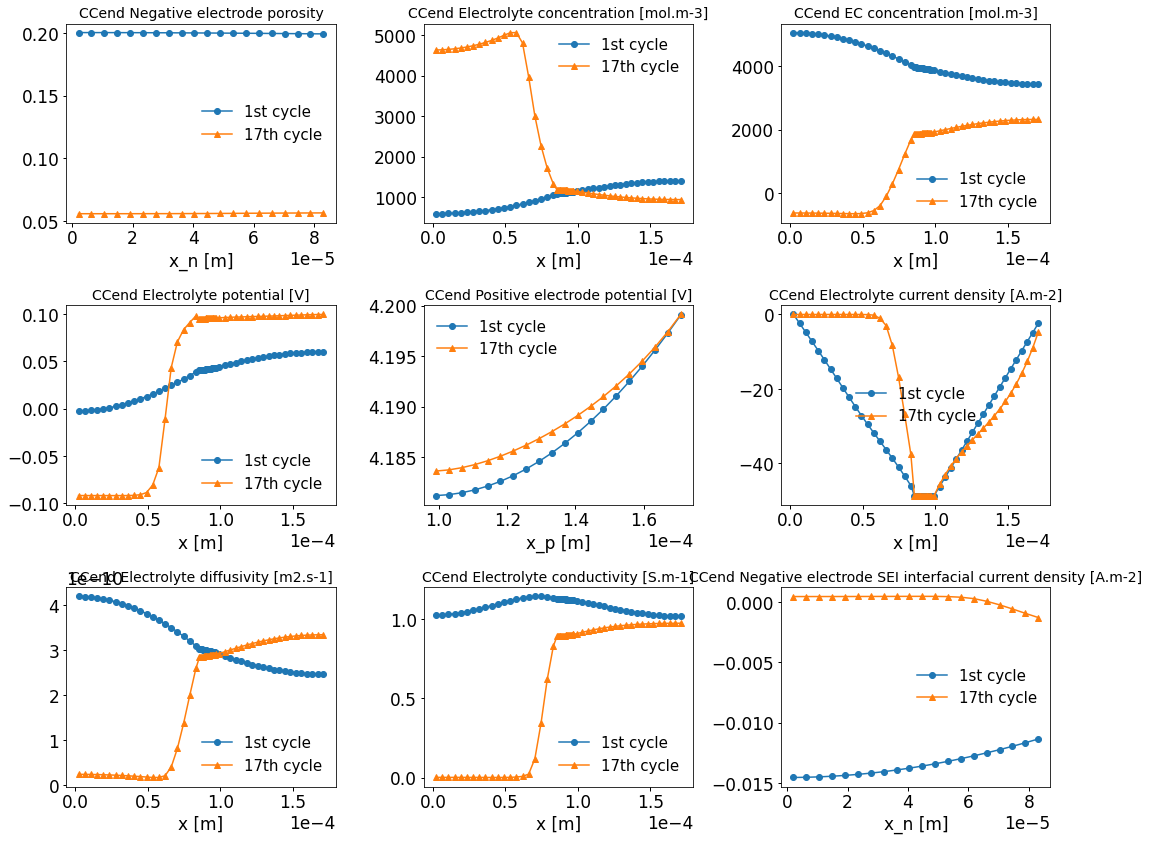

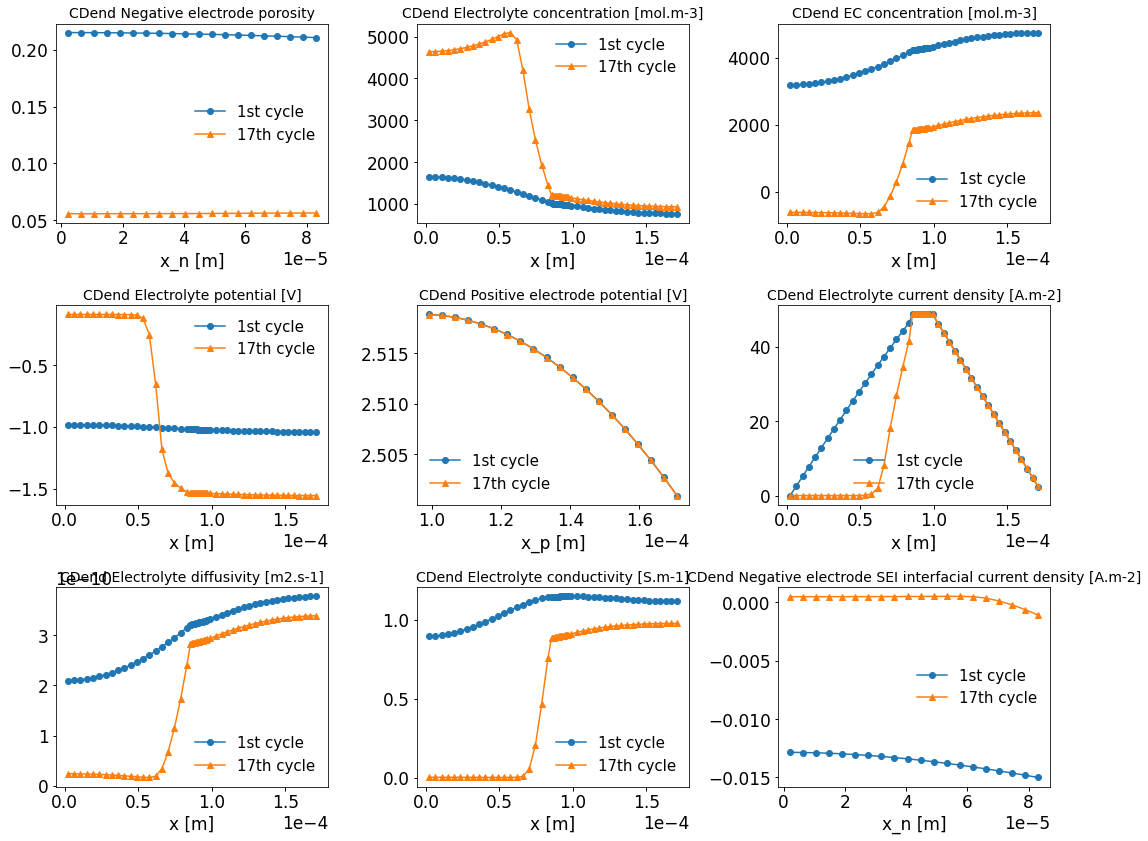

In [19]:
# Plot fig 1~3:
for i in range(0,len(Sol_All_All)):
    Plot_Fig_1(Full_cycle_all[i],my_dict_AGE_all[i],
        BasicPath, Target,   i,  17,  200)

key_all_CCend = [
    "CCend Negative electrode porosity",
    "CCend Electrolyte concentration [mol.m-3]",
    "CCend EC concentration [mol.m-3]",
    "CCend Electrolyte potential [V]",
    "CCend Positive electrode potential [V]",
    "CCend Electrolyte current density [A.m-2]",
    "CCend Electrolyte diffusivity [m2.s-1]",
    "CCend Electrolyte conductivity [S.m-1]",
    "CCend Negative electrode SEI interfacial current density [A.m-2]",
]
key_all_CDend = [
    "CDend Negative electrode porosity",
    "CDend Electrolyte concentration [mol.m-3]",
    "CDend EC concentration [mol.m-3]",
    "CDend Electrolyte potential [V]",
    "CDend Positive electrode potential [V]",
    "CDend Electrolyte current density [A.m-2]",
    "CDend Electrolyte diffusivity [m2.s-1]",
    "CDend Electrolyte conductivity [S.m-1]",
    "CDend Negative electrode SEI interfacial current density [A.m-2]",
]
for i in range(0,len(Sol_All_All)):
    fig, axs = Plot_Loc_Var_2(
        Full_cycle_all[i],key_all_CCend,my_dict_AGE_all[i],17)
    plt.savefig(
        BasicPath + Target+f"{i}th Scan/" +
        "Fig. 2 - CCend Loc based overall.png", dpi=300)
    fig, axs = Plot_Loc_Var_2(
        Full_cycle_all[i],key_all_CDend,my_dict_AGE_all[i],17)
    plt.savefig(
        BasicPath + Target+f"{i}th Scan/" +
        "Fig. 3 - CDend Loc based overall.png", dpi=300)

In [21]:
# write into excel:
for i in range(0,len(Sol_All_All)):
    Para_dict_old = Para_dict_list[i]
    str_exp_AGE_text = str(exp_AGE)

    value_list_temp = list(Para_dict_old.values())
    values = []
    for value_list_temp_i in value_list_temp:
        values.append(str(value_list_temp_i))
    values.insert(0,str(i));
    #"Cap Loss","LLI to SEI",
    #"LAM to Neg","LAM to Pos",
    #"Error"])
    values.extend([
        str_exp_AGE_text,
        str(my_dict_AGE_all[i]["Discharge capacity [A.h]"][0] 
        - 
        my_dict_AGE_all[i]["Discharge capacity [A.h]"][-1]),

        str(my_dict_AGE_all[i]["CDend Loss of capacity to SEI [A.h]"][-1]),
        str(my_dict_AGE_all[i]["CDend Negative electrode capacity [A.h]"][0] 
        - 
        my_dict_AGE_all[i]["CDend Negative electrode capacity [A.h]"][-1]),

        str(my_dict_AGE_all[i]["CDend Positive electrode capacity [A.h]"][0] 
        - 
        my_dict_AGE_all[i]["CDend Positive electrode capacity [A.h]"][-1]),
    ])
    values = [values,]
    book_name_xlsx_seperate =   str(i)+ '_' + book_name_xlsx;
    sheet_name_xlsx =  str(i);
    write_excel_xlsx(
        BasicPath + Target+   book_name_xlsx_seperate, 
        sheet_name_xlsx, values)


Successfully create a excel file
Successfully create a excel file


In [25]:
# Write all seperate excel files into a big file:
for i in range(0,len(Sol_All_All)):
    #print(index_list_i)
    old_book = str(i) + '_' + book_name_xlsx
    #print(old_book)
    #open excel:
    data_old = openpyxl.load_workbook(BasicPath + Target + old_book)   
    data_tar = openpyxl.load_workbook(BasicPath + Target + book_name_xlsx) 

    table_old = data_old.get_sheet_by_name(str(i))
    nrows_old = table_old.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数

    tar_sheet_name_xlsx = 'Results';
    table_tar = data_tar.get_sheet_by_name(tar_sheet_name_xlsx)
    nrows_tar = table_tar.max_row  # 获得行数
    ncolumns_old = table_old.max_column  # 获得列数
    list_old = [];
    #print(nrows_old,nrows_tar)
    for i in range(1,nrows_old+1):
        for j in range(1,ncolumns_old+1):
            list_old.append(table_old.cell(row=i,column=j).value)
    
    list_old = [list_old,]
    for i in range(1, len(list_old)+1):
            for j in range(1, len(list_old[i-1])+1):
                #print(i,j,list_old[i-1][j-1]    )
                table_tar.cell(nrows_tar+i, j).value = list_old[i-1][j-1]     
    data_tar.save(BasicPath + Target + book_name_xlsx) 
    data_tar.close()


